[INFO] loading dataset...
Batch size = 32
Train steps = 4
Validation steps = 4
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 122, 128)     147584    
_________________________________________

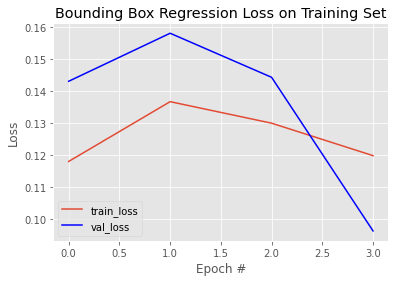

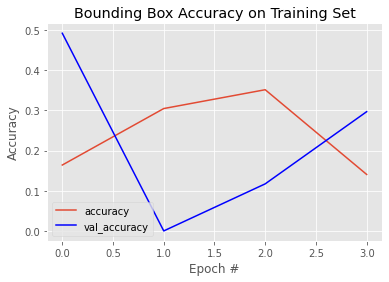

In [1]:
import os
import cv2
import config
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess_data_bb import data_generator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from preprocess_data import read_image_as_array
from preprocess_data import load_train_dataset, load_val_dataset
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, CSVLogger, ReduceLROnPlateau

def train():
    # callbacks
    save_model_callback = ModelCheckpoint(config.model_detector, monitor='val_accuracy', save_best_only=True,
                                          mode='auto', verbose=1, period=1)
    early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True,
                                            verbose=1, patience=15)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', mode='auto', factor=0.5, patience=5,
                                           min_lr=0.00001,verbose=1)

    print("[INFO] loading dataset...")
    print("Batch size =", config.batch_size)
    train_data_gen = data_generator(config.train_dir_bb, config.train_csv, config.batch_size)
    val_data_gen = data_generator(config.val_dir_bb, config.val_csv, config.batch_size)
    
    files_train = [f for f in os.listdir(config.train_dir_bb) if os.path.isfile(os.path.join(config.train_dir_bb, f))]
    train_steps = (len(files_train) // config.batch_size) + 1
    
    files_val = [f for f in os.listdir(config.val_dir_bb) if os.path.isfile(os.path.join(config.val_dir_bb, f))]
    val_steps = (len(files_val) // config.batch_size) + 1
        
    print("Train steps =", train_steps)
    print("Validation steps =", val_steps)
    
    # load the VGG16 network
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 244, 3)))

    vgg.trainable = False

    flatten = vgg.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation='relu')(flatten)
    bboxHead = Dense(64, activation='relu')(bboxHead)
    bboxHead = Dense(32, activation='relu')(bboxHead)
    bboxHead = Dense(4, activation='sigmoid')(bboxHead)

    model = Model(inputs=vgg.input, outputs=bboxHead)

    # initialize the optimizer, compile the model and show the model
    opt = Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # train the network for bounding box regression
    print("[INFO] training bounding box regress...")
    history = model.fit(x=train_data_gen, validation_data=val_data_gen, epochs=config.total_epochs, steps_per_epoch=train_steps, 
                        validation_steps=val_steps, verbose=1, callbacks=[save_model_callback, early_stopping_callback,
                        reduce_lr_callback])

    return history


if __name__ == "__main__":
    H = train()

    N = len(H.history['loss'])
    
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
    plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss', color='blue')
    plt.title('Bounding Box Regression Loss on Training Set')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    plt.savefig(config.plot_path_loss)
    
    plt.figure()
    plt.plot(np.arange(0, N), H.history['accuracy'], label='accuracy')
    plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_accuracy', color='blue')
    plt.title('Bounding Box Accuracy on Training Set')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.savefig(config.plot_path_acc)
